# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernible landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch import nn,optim
import torch.nn.functional as F
from torchvision import datasets,models,transforms as t
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [2]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
batch_size = 16
valid_size = 0.2


transforms_scratch = {'train':t.Compose([t.RandomHorizontalFlip(),
                                         t.RandomResizedCrop(224),
                                         t.RandomRotation(20),
                                         t.ToTensor(),
                                         t.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])]),
                      'valid':t.Compose([t.Resize(255),
                                        t.CenterCrop(224),
                                        t.ToTensor(),
                                        t.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])]),
                      'test':t.Compose([t.Resize(255),
                                        t.CenterCrop(224),
                                        t.ToTensor(),
                                        t.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])}
            

datasets_scratch={'train': datasets.ImageFolder('data/landmark_images/train',transform=transforms_scratch['train']),
                  'valid': datasets.ImageFolder('data/landmark_images/train',transform=transforms_scratch['valid']),
                  'test': datasets.ImageFolder('data/landmark_images/test',transform=transforms_scratch['test'])}

indices = list(range(len(datasets_scratch['train'])))
np.random.shuffle(indices)
split = int(np.floor(valid_size * len(indices)))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

loaders_scratch = {'train': DataLoader(datasets_scratch['train'],batch_size=batch_size,sampler=train_sampler),
                   'valid': DataLoader(datasets_scratch['valid'],batch_size=batch_size,sampler=valid_sampler),
                   'test': DataLoader(datasets_scratch['test'],batch_size=batch_size)}

In [3]:
img,_=next(iter(loaders_scratch['train']))
img.shape

torch.Size([16, 3, 224, 224])

**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**: 
* I designed my transforms to be also compatible with the transfer learning task so the images are cropped to be 224 .224 either by random resized crop for the training and validation or by resizing the image to 255.255 which is close enough to the target and the doing a center crop ignoring the edges of the image.
* I augmented the training data by doing a random horizontal flip because this is common in real world. and I also did a random resize before cropping the image in addition to a random rotation.



### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

In [4]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
def imshow(image,ax):
    image = image.numpy().transpose((1, 2, 0))
    image = image * std + mean
    image = np.clip(image, 0, 1)
    ax.imshow(image)

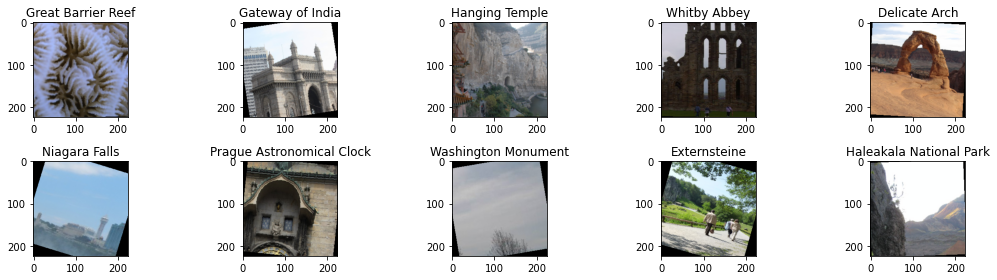

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

## TODO: visualize a batch of the train data loader

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

classes=datasets_scratch['train'].classes
images, labels = next(iter(loaders_scratch['train']))

fig,axes = plt.subplots(2,5,figsize=(15, 4))
axes=axes.flatten()

for i,ax in enumerate(axes):
    imshow(images[i],ax)
    ax.set_title(classes[labels[i]][3:].replace('_', ' '))
    
plt.tight_layout()

### Initialize use_cuda variable

In [6]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [7]:
## TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

def get_optimizer_scratch(model):
    ## TODO: select and return an optimizer
    return optim.SGD(model.parameters(),lr=0.01)

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [8]:
# define the CNN architecture
class Net(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(3, 16, kernel_size=9)    
        self.conv2_1=nn.Conv2d(16,64,kernel_size=3,padding=1)     
        self.conv2_2=nn.Conv2d(64,64,kernel_size=9,stride=3)
        self.conv3_1=nn.Conv2d(64,128,kernel_size=3,padding=1)
        self.conv3_2=nn.Conv2d(128,128,kernel_size=3,stride=2)
        
        self.pool=nn.MaxPool2d(2,2)
        
        self.fc1 = nn.Linear(128*8*8, 512)
        self.fc2 = nn.Linear(512, 50)
        
        self.dropout=nn.Dropout(p=0.2)
        
    def forward(self, x):
        ## Define forward behavior
        x=self.pool(F.relu(self.conv1(x)))
        
        x=F.relu(self.conv2_1(x))
        x=self.pool(F.relu(self.conv2_2(x)))
        
        x=F.relu(self.conv3_1(x))
        x=F.relu(self.conv3_2(x))

        x = x.view(-1, 128 * 8 * 8)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
     
        return x

#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__
* At first, I made a huge network to inccrease the features discovered by the network while reducing dimensionality but it took a lot of time to train so i removed some layers and tried concatinating conv layers before pooling. I achieved good results with a feature vector of size 128.8.8 and the network is so much faster.  

### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [9]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            optimizer.zero_grad()
            out=model(data)
            loss=criterion(out,target)
            loss.backward()
            optimizer.step()
            train_loss += ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            # train_loss += loss.item()*data.size(0)

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            with torch.no_grad():
                # move to GPU
                if use_cuda:
                    data, target = data.cuda(), target.cuda()

                ## TODO: update average validation loss 
                val_out=model(data)
                loss=criterion(val_out,target)
                valid_loss += ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))
                # valid_loss += loss.item()*data.size(0)
                
        # train_loss = train_loss/len(train_loader.sampler)
        # valid_loss = valid_loss/len(valid_loader.sampler)
        
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ... Model saved ...')
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
        
    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [10]:
def custom_weight_init(m):
    ## TODO: implement a weight initialization strategy
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # get the number of the inputs
        n = m.in_features
        y = (1.0/np.sqrt(n))
        m.weight.data.normal_(0, y)
        m.bias.data.fill_(0)

#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init)
model_scratch = train(20, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

C:\Anaconda\envs\aipnd\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 1 	Training Loss: 3.911997 	Validation Loss: 3.907458
Validation loss decreased ... Model saved ...
Epoch: 2 	Training Loss: 3.882959 	Validation Loss: 3.807022
Validation loss decreased ... Model saved ...
Epoch: 3 	Training Loss: 3.825181 	Validation Loss: 3.761344
Validation loss decreased ... Model saved ...
Epoch: 4 	Training Loss: 3.788594 	Validation Loss: 3.685323
Validation loss decreased ... Model saved ...
Epoch: 5 	Training Loss: 3.769594 	Validation Loss: 3.702879
Epoch: 6 	Training Loss: 3.751833 	Validation Loss: 3.668890
Validation loss decreased ... Model saved ...
Epoch: 7 	Training Loss: 3.726669 	Validation Loss: 3.624829
Validation loss decreased ... Model saved ...
Epoch: 8 	Training Loss: 3.703664 	Validation Loss: 3.583793
Validation loss decreased ... Model saved ...
Epoch: 9 	Training Loss: 3.673736 	Validation Loss: 3.540427
Validation loss decreased ... Model saved ...
Epoch: 10 	Training Loss: 3.639079 	Validation Loss: 3.589919
Epoch: 11 	Training L

### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [11]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 50

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 3.912583 	Validation Loss: 3.911744
Validation loss decreased ... Model saved ...
Epoch: 2 	Training Loss: 3.911696 	Validation Loss: 3.910985
Validation loss decreased ... Model saved ...
Epoch: 3 	Training Loss: 3.905297 	Validation Loss: 3.892924
Validation loss decreased ... Model saved ...
Epoch: 4 	Training Loss: 3.857446 	Validation Loss: 3.778989
Validation loss decreased ... Model saved ...
Epoch: 5 	Training Loss: 3.816756 	Validation Loss: 3.733495
Validation loss decreased ... Model saved ...
Epoch: 6 	Training Loss: 3.786425 	Validation Loss: 3.748016
Epoch: 7 	Training Loss: 3.772804 	Validation Loss: 3.714604
Validation loss decreased ... Model saved ...
Epoch: 8 	Training Loss: 3.750937 	Validation Loss: 3.690307
Validation loss decreased ... Model saved ...
Epoch: 9 	Training Loss: 3.741191 	Validation Loss: 3.679514
Validation loss decreased ... Model saved ...
Epoch: 10 	Training Loss: 3.724082 	Validation Loss: 3.656526
Validation loss decre

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [12]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        with torch.no_grad():
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # update average test loss 
            test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
            # convert output probabilities to predicted class
            pred = output.data.max(1, keepdim=True)[1]
            # compare predictions to true label
            correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.609096


Test Accuracy: 34% (435/1250)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [13]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
torch.cuda.empty_cache()
loaders_transfer = loaders_scratch

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [14]:
## TODO: select loss function
criterion_transfer = nn.CrossEntropyLoss()


def get_optimizer_transfer(model):
    ## TODO: select and return optimizer
    return optim.SGD(model.fc.parameters(),lr=0.015,momentum=0.015)

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [15]:
## TODO: Specify model architecture

model_transfer = models.resnet50(pretrained=True)

for param in model_transfer.parameters():
        param.requires_grad = False

model_transfer.fc=nn.Sequential(nn.Dropout(p=0.2),
                                nn.Linear(2048,512),
                                nn.ReLU(),
                                nn.Dropout(p=0.2),
                                nn.Linear(512,50))

#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()

__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  
* I tried resnet50 as it is a fairly fast model and small model.
* I freezed the model parameters then replaced the classifier with another one that have 50 output classes and used and the relu activation function with dropout to prevent overfitting 

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [16]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'
model_transfer = train(15, loaders_transfer, model_transfer, get_optimizer_transfer(model_transfer),
                       criterion_transfer, use_cuda, 'model_transfer.pt')

#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 3.775164 	Validation Loss: 3.394954
Validation loss decreased ... Model saved ...
Epoch: 2 	Training Loss: 3.233916 	Validation Loss: 2.586505
Validation loss decreased ... Model saved ...
Epoch: 3 	Training Loss: 2.687236 	Validation Loss: 2.041991
Validation loss decreased ... Model saved ...
Epoch: 4 	Training Loss: 2.341958 	Validation Loss: 1.703843
Validation loss decreased ... Model saved ...
Epoch: 5 	Training Loss: 2.112795 	Validation Loss: 1.550815
Validation loss decreased ... Model saved ...
Epoch: 6 	Training Loss: 1.978151 	Validation Loss: 1.409914
Validation loss decreased ... Model saved ...
Epoch: 7 	Training Loss: 1.857822 	Validation Loss: 1.318783
Validation loss decreased ... Model saved ...
Epoch: 8 	Training Loss: 1.812739 	Validation Loss: 1.281283
Validation loss decreased ... Model saved ...
Epoch: 9 	Training Loss: 1.751327 	Validation Loss: 1.192543
Validation loss decreased ... Model saved ...
Epoch: 10 	Training Loss: 1.694347 	V

<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [17]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 1.035413


Test Accuracy: 72% (906/1250)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [18]:
## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def predict_landmarks(img_path, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    img = transforms_scratch['test'](Image.open(img_path)).unsqueeze(0)

    model_transfer.load_state_dict(torch.load('model_transfer.pt'))
    model_transfer.eval()
    preds = model_transfer.forward(img.cuda())
    
    top_classes = preds.topk(k)[1]
    final_preds = [datasets_scratch['train'].classes[i][3:].replace('_', ' ') for i in top_classes[0]]
    return final_preds


# test on a sample image
predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

['Forth Bridge',
 'Golden Gate Bridge',
 'Sydney Harbour Bridge',
 'Brooklyn Bridge',
 'Sydney Opera House']

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

Is this picture of the
Forth Bridge, Golden Gate Bridge, Sydney Harbour Bridge?


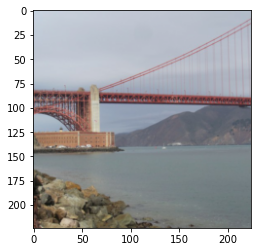

In [19]:
def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)
    
    ## TODO: display image and display landmark predictions
    img=transforms_scratch['test'](Image.open(img_path))
    img=img.numpy().transpose(1,2,0)*std+mean
    plt.imshow(img.clip(0,1))
    print(f"Is this picture of the\n{', '.join(predicted_landmarks)}?")
    
    

# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)
* It met my expectation but it can achieve better results with some impeovements
* We can train on better data as I think the data have some mistakes and noise that mislead the model for sure.
* We can also experiment different types of augmentation.
* We can train for more epochs and try different optimizers with different learning rates and momentum
* We can also use other pretrained models or more layered resnet. This of course has to improve our results 

Is this picture of the
Vienna City Hall, Taj Mahal, Eiffel Tower?


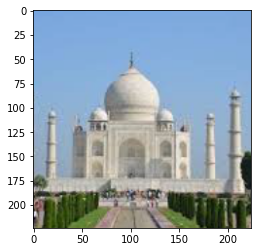

In [20]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.
suggest_locations('./test1.jpg')


Is this picture of the
Sydney Opera House, Forth Bridge, Sydney Harbour Bridge?


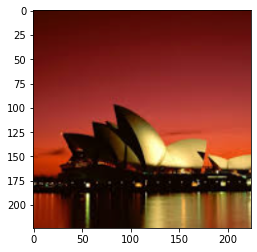

In [21]:
suggest_locations('test2.jpg')

Is this picture of the
Eiffel Tower, Vienna City Hall, Gateway of India?


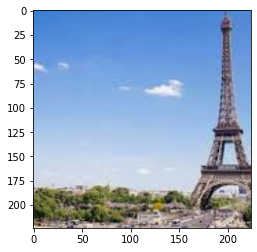

In [22]:
suggest_locations('test3.jpg')

Is this picture of the
Mount Rushmore National Memorial, Edinburgh Castle, Taj Mahal?


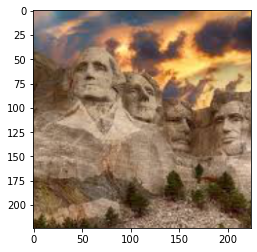

In [23]:
suggest_locations('test4.jpg')

Is this picture of the
Trevi Fountain, Badlands National Park, Temple of Heaven?


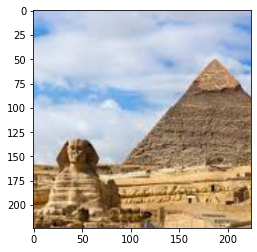

In [24]:
suggest_locations('test5.jpg')

Is this picture of the
Golden Gate Bridge, Forth Bridge, Brooklyn Bridge?


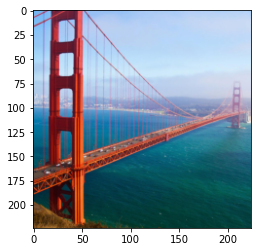

In [25]:
suggest_locations('test6.jpg')